In [1]:
!pip install tensorflow==2.0.0

     |████████████████████████████████| 86.3MB 79kB/s 
     |████████████████████████████████| 450kB 44.6MB/s 
     |████████████████████████████████| 51kB 6.3MB/s 
     |████████████████████████████████| 3.8MB 53.3MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=8e05ffadd2323488dfee6cdff08350ae040a34723a5a908182ac24eacf4166d8
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstal

In [1]:
import tensorflow as tf 
tf.__version__

'2.4.1'

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!ls "/content/drive/My Drive/Colab_Notebooks"


'Computer Vision.ipynb'   images.npy   Labels.csv


In [42]:
# import needed libraries
import os as os
from PIL import Image
from array import array
import cv2 as cv2
from glob import glob
import time
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn import preprocessing
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import itertools

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,Activation
from tensorflow.keras.optimizers import Adam,RMSprop
from keras.utils.np_utils import to_categorical  


In [94]:
# Import the libraries, load dataset, print shape of data, visualize the images in dataset

trainImg = np.load('drive/My Drive/Colab_Notebooks/images.npy')
trainLabel = pd.read_csv('drive/My Drive/Colab_Notebooks/Labels.csv')
print(trainImg.shape)
print(trainLabel.shape)

(4750, 128, 128, 3)
(4750, 1)


In [96]:
# Check value counts
trainLabel['Label'].value_counts()

Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Common wheat                 221
Maize                        221
Name: Label, dtype: int64

Text(0.5, 1.0, 'Loose Silky-bent')

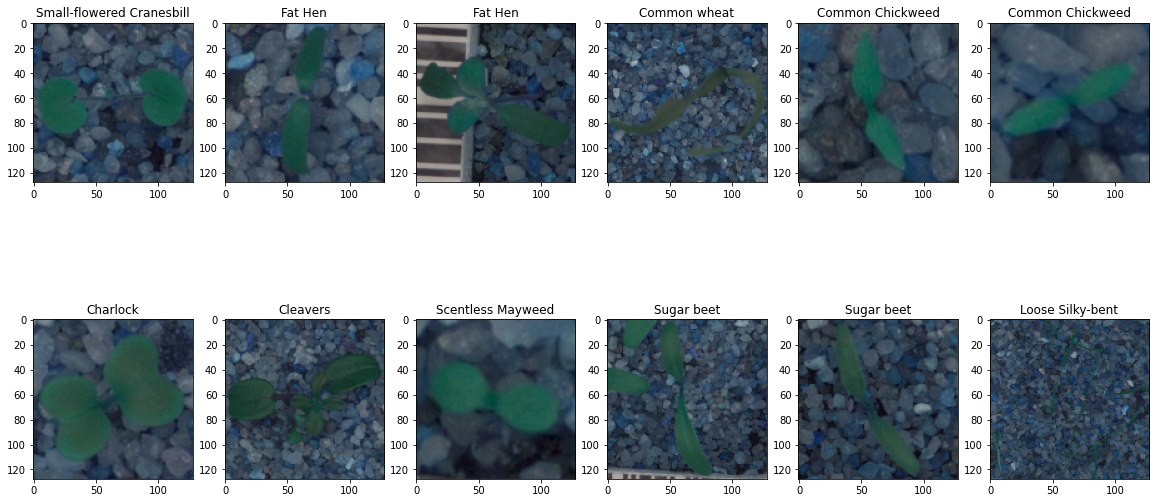

In [97]:
# Visualize Images from dataset

f = plt.figure(figsize=(20, 20))

f.add_subplot(2, 6, 1)
plt.imshow(trainImg[0])
plt.title(trainLabel['Label'][0])

f.add_subplot(2, 6, 2)
plt.imshow(trainImg[496])
plt.title(trainLabel['Label'][496])

f.add_subplot(2, 6, 3)
plt.imshow(trainImg[759])
plt.title(trainLabel['Label'][759])
 
f.add_subplot(2, 6, 4)
plt.imshow(trainImg[1370])
plt.title(trainLabel['Label'][1370])

f.add_subplot(2, 6, 5)
plt.imshow(trainImg[1755])
plt.title(trainLabel['Label'][1755])

f.add_subplot(2, 6, 6)
plt.imshow(trainImg[1685])
plt.title(trainLabel['Label'][1685])

f.add_subplot(1, 6, 1)
plt.imshow(trainImg[2409])
plt.title(trainLabel['Label'][2409])

f.add_subplot(1, 6, 2)
plt.imshow(trainImg[2630])
plt.title(trainLabel['Label'][2630])

f.add_subplot(1, 6, 3)
plt.imshow(trainImg[3020])
plt.title(trainLabel['Label'][3020])
 
f.add_subplot(1, 6, 4)
plt.imshow(trainImg[3251])
plt.title(trainLabel['Label'][3251])

f.add_subplot(1, 6, 5)
plt.imshow(trainImg[3538])
plt.title(trainLabel['Label'][3538])

f.add_subplot(1, 6, 6)
plt.imshow(trainImg[4749])
plt.title(trainLabel['Label'][4749])

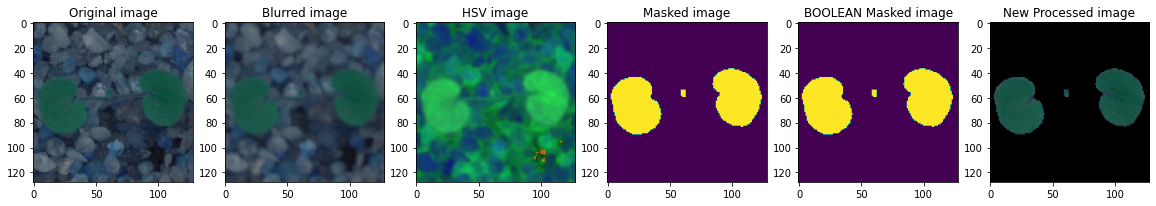

In [98]:
# GaussianBlur

trainImg_new = []
getEx = True

for i in trainImg:
    # Blurred image
    blurr = cv2.GaussianBlur(i,(5,5),0)
    # HSV image
    hsv = cv2.cvtColor(blurr,cv2.COLOR_BGR2HSV)

    #Green Parameters
    sensitivity = 35
    lower  = np.array([60 - sensitivity, 100, 50])
    upper = np.array([60 + sensitivity, 255, 255])
    
    #Masked image
    mask = cv2.inRange(hsv,lower,upper)
    struc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    mask = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,struc)
    
    #Boolean image
    boolean = mask>0
    new = np.zeros_like(i,np.uint8)
    new[boolean] = i[boolean]
    trainImg_new.append(new)
    
    if getEx:
        f = plt.figure(figsize=(20, 20))
        f.add_subplot(1,6,1);plt.imshow(i);plt.title('Original image') # Original image
        f.add_subplot(1,6,2);plt.imshow(blurr);plt.title('Blurred image') # Blurred image
        f.add_subplot(1,6,3);plt.imshow(hsv);plt.title('HSV image') # HSV image
        f.add_subplot(1,6,4);plt.imshow(mask);plt.title('Masked image') # Masked image
        f.add_subplot(1,6,5);plt.imshow(boolean);plt.title('BOOLEAN Masked image') # BOOLEAN Masked image
        f.add_subplot(1,6,6);plt.imshow(new);plt.title('New Processed image') # New Processed image
        getEx = False
        
trainImg_new = np.asarray(trainImg_new)

In [99]:
# check shape
trainImg_new.shape


(4750, 128, 128, 3)

In [100]:
# One Hot Encoding
labels = preprocessing.LabelEncoder()
labels.fit(trainLabel['Label'])
print('Classes'+str(labels.classes_))

Classes['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'Shepherds Purse' 'Small-flowered Cranesbill' 'Sugar beet']


In [102]:
encodedlabel = labels.transform(trainLabel['Label'])
convertedlabels = np_utils.to_categorical(encodedlabel)
classes = convertedlabels.shape[1]
print(str(classes))

12


In [108]:
# Normalization 
trainImg_new = trainImg_new.astype('float32') / 255.0

In [106]:
# Print the label for y_train[0]
y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)

In [24]:
# First split images andlabels into training and testing set with test_size = 0.3
X_train,X_test,y_train,y_test = train_test_split(trainImg_new,convertedlabels,test_size=0.3,random_state=38,stratify=convertedlabels)

In [109]:
# Check  the  shape  of  data
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3325, 128, 128, 3)
(3325, 12)
(1425, 128, 128, 3)
(1425, 12)


In [110]:
# Split test data into test and validation set with test_size = 0.5
X_val,X_test_new,y_val,y_test_new = train_test_split(X_test,y_test,test_size=0.5,random_state=38,stratify=y_test)

In [112]:
# Check  the  shape  of  data
print(X_val.shape)
print(y_val.shape)
print(X_test_new.shape)
print(y_test_new.shape)

(712, 128, 128, 3)
(712, 12)
(713, 128, 128, 3)
(713, 12)


In [107]:
# Get Label of i=10
labels.classes_[10]

'Small-flowered Cranesbill'

In [113]:
# Building CNN model
# CNN Model 1
# 2 convolution layers ( filters=64 / 128 , kernel_size=(3, 3) activation='relu')
# MaxPool2D((2, 2)
# Dropout(0.25)
# Flatten
# 2 dense layers (128 / 64, activation='relu')
# Dropout(0.25)
# loss='categorical_crossentropy', optimizer='adam'
# model compile with ImageDataGenerator to minimize overfitting.
# shuffle = True

generator = ImageDataGenerator(rotation_range = 180,
                               zoom_range = 0.2,
                               width_shift_range = 0.2,
                               height_shift_range = 0.2,
                               horizontal_flip = True,
                               vertical_flip = True)
generator.fit(X_train)

In [114]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=(128, 128, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 126, 126, 64)      1792      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 63, 63, 64)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 61, 61, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 128)      

In [115]:
history = model.fit(generator.flow(X_train,y_train,batch_size=64),epochs=200, verbose=2,shuffle=True,validation_data=(X_val,y_val))
pd.DataFrame(history.history)

Epoch 1/200
52/52 - 12s - loss: 2.1660 - accuracy: 0.2466 - val_loss: 1.7970 - val_accuracy: 0.4340
Epoch 2/200
52/52 - 11s - loss: 1.7424 - accuracy: 0.3817 - val_loss: 1.5396 - val_accuracy: 0.5070
Epoch 3/200
52/52 - 11s - loss: 1.5346 - accuracy: 0.4629 - val_loss: 1.3760 - val_accuracy: 0.5281
Epoch 4/200
52/52 - 11s - loss: 1.4369 - accuracy: 0.4953 - val_loss: 1.2098 - val_accuracy: 0.6025
Epoch 5/200
52/52 - 11s - loss: 1.3700 - accuracy: 0.5218 - val_loss: 1.2117 - val_accuracy: 0.6264
Epoch 6/200
52/52 - 11s - loss: 1.3238 - accuracy: 0.5411 - val_loss: 1.1016 - val_accuracy: 0.6447
Epoch 7/200
52/52 - 11s - loss: 1.2891 - accuracy: 0.5510 - val_loss: 1.0928 - val_accuracy: 0.6685
Epoch 8/200
52/52 - 11s - loss: 1.1891 - accuracy: 0.5786 - val_loss: 1.0838 - val_accuracy: 0.6545
Epoch 9/200
52/52 - 11s - loss: 1.1460 - accuracy: 0.5991 - val_loss: 1.0061 - val_accuracy: 0.6784
Epoch 10/200
52/52 - 11s - loss: 1.0995 - accuracy: 0.6274 - val_loss: 0.9585 - val_accuracy: 0.6994

,loss,accuracy,val_loss,val_accuracy
0,2.165982,0.246617,1.797018,0.433989
1,1.742378,0.381654,1.539556,0.507023
2,1.534553,0.462857,1.375957,0.528090
3,1.436850,0.495338,1.209773,0.602528
4,1.369982,0.521805,1.211654,0.626405
...,...,...,...,...
195,0.264543,0.902556,0.388932,0.893258
196,0.253689,0.898045,0.415940,0.893258
197,0.259980,0.900150,0.429517,0.866573
198,0.237407,0.911278,0.454536,0.852528


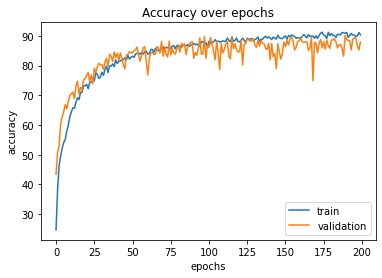

In [116]:
# Plot Training Accuracy vs Validation Accuracy
plt.plot(np.array(history.history['accuracy']) * 100)
plt.plot(np.array(history.history['val_accuracy']) * 100)
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'validation'])
plt.title('Accuracy over epochs')
plt.show()

In [117]:
# Print Test Loss and Test Accuracy
scores = model.evaluate(X_test_new, y_test_new)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

23/23 [==============================] - 0s 13ms/step - loss: 0.2808 - accuracy: 0.8976
Test loss: 0.28080883622169495
Test accuracy: 0.8976157307624817


In [118]:
# confusion matrix function

def plot_confusion_matrix(cm, classes, normalize=False,title='Confusion matrix',cmap=plt.cm.Greens):
    
    fig = plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

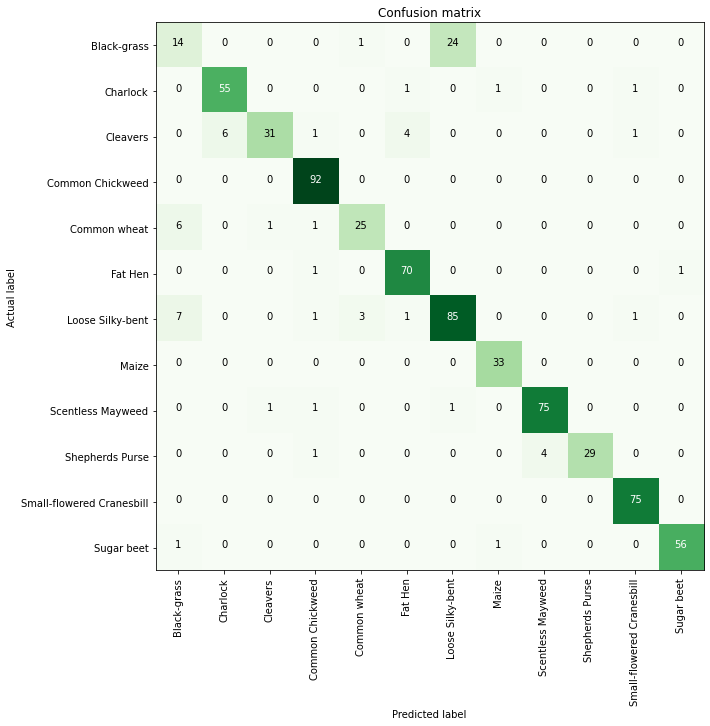

In [119]:
# Predict the values from the test data
y_pred = model.predict(X_test_new)
y_pred_Classes = np.argmax(y_pred, axis = 1) 
trueY = np.argmax(y_test_new, axis = 1) 

# confusion matrix
confusionMTX = confusion_matrix(trueY, y_pred_Classes) 

# plot the confusion matrix
plot_confusion_matrix(confusionMTX, classes = labels.classes_) 

In [120]:
#Final score and accuracy of the model

score, acc = model.evaluate(X_test_new,y_test_new)
score1, acc1 = model.evaluate(X_train,y_train)
print('Test score:', score,'   Test accuracy:', acc)
print('Train score:', score1,'   Train accuracy:',acc1)

104/104 [==============================] - 1s 11ms/step - loss: 0.2094 - accuracy: 0.9185
Test score: 0.28080883622169495    Test accuracy: 0.8976157307624817
Train score: 0.2093685418367386    Train accuracy: 0.9184962511062622


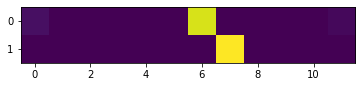

In [121]:
# Visualize Model Predictions
plt.imshow(model.predict(X_test[:2]))



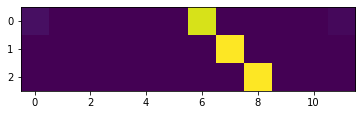

In [122]:
# Visualize Model Predictions
plt.imshow(model.predict(X_test[:3]))

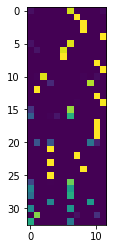

In [123]:
# Visualize Model Predictions
plt.imshow(model.predict(X_test[:33]))

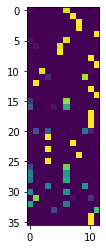

In [124]:
# Visualize Model Predictions
plt.imshow(model.predict(X_test[:36]))

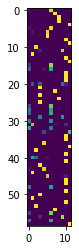

In [125]:
# Visualize Model Predictions
plt.imshow(model.predict(X_test[:59]))

In [126]:
# CNN Model 2
# 3 convolution layers (filters=64/128/128 , kernel_size=(3, 3) activation='relu')
# MaxPool2D((2, 2),
# Dropout(0.25)
# Flatten
# 1 dense layer (256, activation='relu')
# Dropout(0.5)
# loss='categorical_crossentropy', optimizer='adam'
# model compile with ImageDataGenerator to minimize overfitting.
# shuffle = True
generator = ImageDataGenerator(rotation_range = 180,
                               zoom_range = 0.2,
                               width_shift_range = 0.2,
                               height_shift_range = 0.2,
                               horizontal_flip = True,
                               vertical_flip = True)
generator.fit(X_train)

In [127]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=(128, 128, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 126, 126, 64)      1792      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 63, 63, 64)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 61, 61, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 30, 30, 128)       0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 128)      

In [128]:
history = model.fit(generator.flow(X_train,y_train,batch_size=64),epochs=100, verbose=2,shuffle=True,validation_data=(X_val,y_val))
pd.DataFrame(history.history)

Epoch 1/100
52/52 - 12s - loss: 2.1735 - accuracy: 0.2481 - val_loss: 1.8076 - val_accuracy: 0.4228
Epoch 2/100
52/52 - 11s - loss: 1.7375 - accuracy: 0.3988 - val_loss: 1.4159 - val_accuracy: 0.5154
Epoch 3/100
52/52 - 11s - loss: 1.5404 - accuracy: 0.4532 - val_loss: 1.3658 - val_accuracy: 0.5716
Epoch 4/100
52/52 - 11s - loss: 1.4436 - accuracy: 0.4896 - val_loss: 1.2418 - val_accuracy: 0.6025
Epoch 5/100
52/52 - 11s - loss: 1.3602 - accuracy: 0.5293 - val_loss: 1.1879 - val_accuracy: 0.6306
Epoch 6/100
52/52 - 11s - loss: 1.2888 - accuracy: 0.5525 - val_loss: 1.1443 - val_accuracy: 0.6264
Epoch 7/100
52/52 - 11s - loss: 1.2128 - accuracy: 0.5747 - val_loss: 1.0448 - val_accuracy: 0.6587
Epoch 8/100
52/52 - 11s - loss: 1.1842 - accuracy: 0.5922 - val_loss: 1.0384 - val_accuracy: 0.6559
Epoch 9/100
52/52 - 11s - loss: 1.1247 - accuracy: 0.6123 - val_loss: 1.0036 - val_accuracy: 0.6699
Epoch 10/100
52/52 - 11s - loss: 1.0727 - accuracy: 0.6223 - val_loss: 0.8965 - val_accuracy: 0.7093

,loss,accuracy,val_loss,val_accuracy
0,2.173515,0.248120,1.807578,0.422753
1,1.737459,0.398797,1.415933,0.515449
2,1.540430,0.453233,1.365769,0.571629
3,1.443644,0.489624,1.241773,0.602528
4,1.360205,0.529323,1.187851,0.630618
...,...,...,...,...
95,0.336671,0.871278,0.461574,0.867977
96,0.319195,0.877293,0.449535,0.869382
97,0.345541,0.872180,0.464125,0.860955
98,0.315225,0.883308,0.424854,0.880618


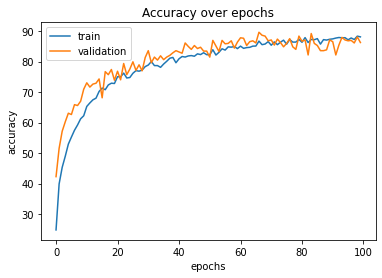

In [129]:
# Plot Training Accuracy vs Validation Accuracy
plt.plot(np.array(history.history['accuracy']) * 100)
plt.plot(np.array(history.history['val_accuracy']) * 100)
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'validation'])
plt.title('Accuracy over epochs')
plt.show()

In [130]:
# Test Loss vs Test Accuracy
scores = model.evaluate(X_test_new, y_test_new)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

23/23 [==============================] - 0s 14ms/step - loss: 0.3079 - accuracy: 0.8780
Test loss: 0.30794474482536316
Test accuracy: 0.8779803514480591


In [131]:
# confusion matrix function

def plot_confusion_matrix(cm, classes, normalize=False,title='Confusion matrix',cmap=plt.cm.Greens):
    
    fig = plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

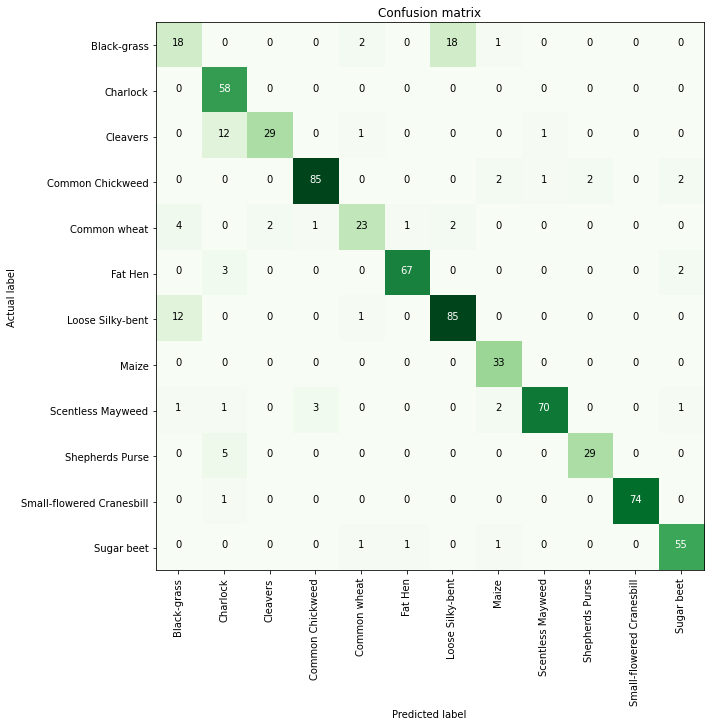

In [132]:
# Predict the values from the test data
y_pred = model.predict(X_test_new)
y_pred_Classes = np.argmax(y_pred, axis = 1) 
trueY = np.argmax(y_test_new, axis = 1) 

# confusion matrix
confusionMTX = confusion_matrix(trueY, y_pred_Classes) 

# plot the confusion matrix
plot_confusion_matrix(confusionMTX, classes = labels.classes_) 

In [133]:
#Final score and accuracy of the model

score, acc = model.evaluate(X_test_new,y_test_new)
score1, acc1 = model.evaluate(X_train,y_train)
print('Test score:', score,'   Test accuracy:', acc)
print('Train score:', score1,'   Train accuracy:',acc1)

104/104 [==============================] - 1s 11ms/step - loss: 0.2605 - accuracy: 0.8959
Test score: 0.30794474482536316    Test accuracy: 0.8779803514480591
Train score: 0.26045843958854675    Train accuracy: 0.895939826965332


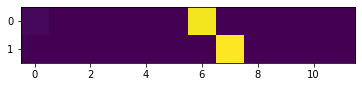

In [134]:
# Visualize Model Predictions
plt.imshow(model.predict(X_test[:2]))



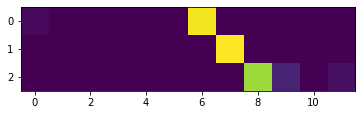

In [135]:
plt.imshow(model.predict(X_test[:3]))


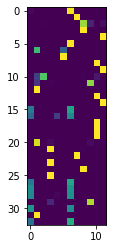

In [136]:
plt.imshow(model.predict(X_test[:33]))

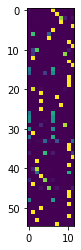

In [137]:
plt.imshow(model.predict(X_test[:55]))


### Conclusion:

**CNN models:**


---


**1.   CNN Model 1**

     *   2 convolution layers ( filters=64 / 128 , kernel_size=(3, 3) activation='relu') 
     * MaxPool2D((2, 2)
     * Dropout(0.25)
     * Flatten
     * 2 dense layers (128 / 64, activation='relu')
     * Dropout(0.25)
     * loss='categorical_crossentropy', optimizer='adam'
     * model compile with ImageDataGenerator to minimize overfitting.
     * shuffle = True

**2.   CNN Model 2**

     * 3 convolution layers (filters=64/128/128 , kernel_size=(3, 3) activation='relu') 
     * MaxPool2D((2, 2)
     * Dropout(0.25)
     * Flatten
     * 1 dense layer (256, activation='relu')
     * Dropout(0.5)
     * loss='categorical_crossentropy', optimizer='adam'
     * model compile with ImageDataGenerator to minimize overfitting.
     * shuffle = True

**Model Outcomes:**


---

|                    | CNN Model 1          | CNN Model 2 |
| -----------        | -----------          | ----------- |
| **Train Score**    | 0.2093685418367386   | 0.26045843958854675            |
| **Train Accuracy** | 0.9184962511062622   | 0.895939826965332            |
| **Test Score**     | 0.28080883622169495  | 0.30794474482536316            |
| **Test Accuracy**  | 0.8976157307624817   | 0.8779803514480591            |
| **Test Loss**      | 0.28080883622169495  | 0.30794474482536316             |